# Budworm Example
# Investigate Weak formulation of ode solution for loss
Consider the stiff ode 

$$
\dot{x} = F(x;u), \quad x \in \Omega \subseteq \mathbb{R}^d
$$

Where we wish to learn $F$ via a paremterized $F_\theta$ via some (possibly noisy) observations $\{x_i\}_{i=1}^n$
Consider the test function $\{\phi_k\}_{k\in[K]} \in H^1$ (sobolev space) that is locally compact on an interval $T$ and a fixed $k$ we have

$$
\int_T \phi_k(t) \dot{x} dt = \int_T \phi_i(t)F(x;u)  dt
$$
$$
\underbrace{\phi_k(t)x \bigg|_{\partial T}}_{=0} - \int_T  \dot{\phi}_k(t)x(t)dt = \int_T \phi_k(t)F(x;u)  dt
$$

We can then define the following residual

$$
R_k(\theta) = \int_T \underbrace{\left(\dot{\phi}_k(t) x(t) + \phi_k(t) F_\theta(x;u)\right)}_{=I_k(t)}dt
$$
where can use a trapezodial rule to approximate the integral

$$
R_k \approx \hat{R}_k \triangleq \sum_{i=1}^{n-1} \frac{\Delta t_i}{2} \left[I_k(t_i) + I_k(t_{i+1})\right] = \mathcal{O}(\Delta t ^{p+1})
$$


<!-- $$
I_k(\theta)\triangleq \sum_{i=1}^n w_i \cdot \phi_k(t_i)\cdot F_\theta(x_i;u_i)\cdot\Delta t_i
$$
$$
D_k \triangleq -1 \cdot \sum_{i=1}^n w_i \cdot x_i \cdot \dot{\phi}_k(t_i)\cdot \Delta t_i
$$

to be quadrature approximations of the integrals above -->

We then define the least squares loss to be

$$
\mathcal{L}(\theta) \triangleq \sum_{k=1}^K \left| \hat{R}_k(\theta) \right|^2.
$$

Where the loss $\mathcal{L}$ can be minimzed in a classical optimizaiton approach. As well as NODE approach. Where we first try and let 

$$
F_\theta(x;u) := \texttt{StabNODE(Felu, Gelu)}
$$

where $\theta$ are the tunable parameters in $\texttt{Felu}$ and $\texttt{Gelu}$


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from stabnode.utils import set_global_seed
from sklearn.preprocessing import MinMaxScaler

seed = 1234
set_global_seed(seed=seed)

### Test functions ($\phi$) from [Weak SINDY: Galerkin-based Data-Driven Model Selection](https://arxiv.org/abs/2005.04339) 

Let $\mathcal{S}$ be the space of unimodal piecewise polynomials

$$
\phi(t) = \begin{cases}
    C(t-a)^p(b-t)^q, & t \in [a,b]\\
    0, & \text{otherwise},
\end{cases}
$$
with $(a,b) \subset t\times t$, $a<b$, and $p,q \geq 1$. And the normalization constant give by 
$$
C = \frac{1}{p^p q^q}\left(\frac{p+q}{b-a}\right)^{p+q}
$$

We also include the first derivative



$$
\partial_t \phi(t) = \begin{cases}
C \bigg(p(t-a)^{p-1}(b-t)^q - (t-a)^pq(b-t)^{q-1}\bigg), & t\in [a,b]\\
0, & \text{otherwise},
\end{cases}
$$

In [2]:
# a,b,p,q = 1,4,1,1
def phi(t:torch.Tensor,a:float,b:float,p:float,q:float)->torch.Tensor:
    C = (1 / ((p**p)*(q**q)))*((p+q)/(b-a))**(p+q)
    vals = torch.zeros_like(t)
    mask = (t>a) & (t<b)
    vals[mask] = C*(t[mask]-a)**p*(b-t[mask])**q
    return vals

def dphi(t:torch.Tensor,a:float,b:float,p:float,q:float)->torch.Tensor:
    C = (1 / ((p**p)*(q**q)))*((p+q)/(b-a))**(p+q)
    vals = torch.zeros_like(t)
    mask = (t>a) & (t<b)
    term1 = p*(t[mask]-a)**(p-1)*(b-t[mask])**q
    term2 = (t[mask]-a)**p*q*(b-t[mask])**(q-1)
    vals[mask] = C*(term1-term2)
    return vals


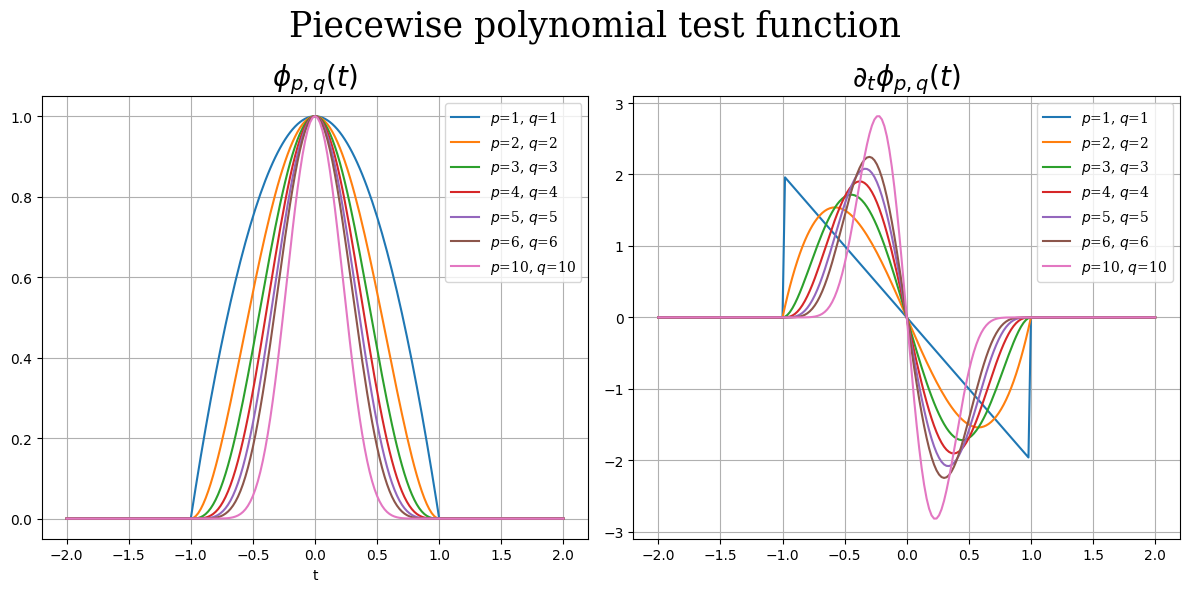

In [3]:
fig, (ax1,ax2)  = plt.subplots(1,2,figsize=(12,6))

t_vals = torch.linspace(-2,2,201)
a,b=-1,1
ps = [1,2,3,4,5,6,10]
qs = [1,2,3,4,5,6,10]
for p,q in zip(ps,qs):
    label = rf"$p$={p}, $q$={q}"
    ax1.plot(t_vals,phi(t_vals,a,b,p,q),label=label)
    ax2.plot(t_vals,dphi(t_vals,a,b,p,q),label=label)
ax1.grid(True)
ax1.set_title(r"$\phi_{p,q}(t)$",size=20,family='serif')
ax1.set_xlabel(r"t")
ax1.legend(prop={'family':'serif'})
ax2.grid(True)
ax2.set_title(r"$\partial_t\phi_{p,q}(t)$",size=20,family='serif')
ax2.legend(prop={'family':'serif'})
plt.suptitle("Piecewise polynomial test function",family='serif',size=25)
plt.tight_layout()
plt.savefig("piecewise_poly_test_functions.png")
plt.show()

In [4]:
from stabnode.node import StabNODE, Felu, Gelu
from data.budworm import simulate_steady_state, budworm_ode
from scipy.integrate import solve_ivp

## Try weak form on budworm learning with smooth control

$$
\dot{x} = rx(1-x/k)-\frac{x^2}{1+x^2}
$$

where we can rewrite in the form 
$$
\dot{x} = f(x)(x - g(x,k))
$$

with 
$$
f(x)= -\frac{x}{1+x^2} \quad \text{and} \quad g(x,k;r) = \frac{r}{k}(1+x^2)(k-x)
$$

$$
g(x,k;r)=-\frac{r}{k}x^3 + rx^2-\frac{r}{k}x+r
$$


### We try and estimate time to steady state ($t^\star$)
Do first order expansion of $f$ and $g$ around steady state values $x_s$, for a fixed value $k$. That is $x_s$ is a function of $k$.

$$
f(x) = f(x_s) + f'(x_s)(x-x_s) + \mathcal{O}(\Delta x^2)
$$

$$
g(x,k) = g(x_s,k) + g'(x_s,k)(x-x_s) + \mathcal{O}(\Delta x^2) = x_s + g'(x_s, k)(x-x_s) + \mathcal{O}(\Delta x^2)
$$
Where we have a first order expansion of our dynamical system
$$
\begin{align}
\dot{x} &\approx f(x_s) \cdot \left[x - x_s - g'(x_s,k)(x-x_s) - \mathcal{O}(\Delta x^2)\right]\\
&= f(x_s)\cdot \left[1 - g'(x_s,k) - \mathcal{O}(\Delta x)\right]\Delta x\\
&\approx f(x_s) \cdot \left[1-g'(x_s,k)\right](x-x_s)
\end{align}

$$

In [5]:
def f_true(x):
    return -1*x / (1+x**2)

def g_true(x,k,r):
    return -(r/k)*x**3 + r*x**2 -(r/k)*x +r 
def dg_true(x,k,r):
    return -2*(r/k)*x**2 + 2*r*x - (r/k)


In [6]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
r1,r2


(6.44569072482332, 9.93441120446710)

In [7]:
k1 = r1-1.1
k2 = r2+1.1

def k_func(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

In [8]:
def budworm_steady_states(k,r):
    """
    for a given k and r return real x such that 
    g(x,k:r) = x

    find roots of polynomial 
    p(x) = g(x,k;r)-x = -r/k x^3 + rx^2 -(r/k+1)x+r
    """
    a = -r/k
    b = r
    c=-(r/k + 1)
    d = r
    roots = np.roots([a,b,c,d])
    real_idx = np.isreal(roots)

    return sorted([r.real for r in roots if np.isreal(r)])
    

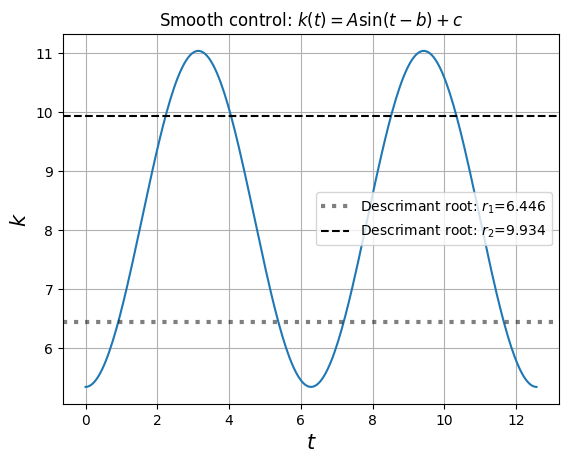

5.34569072482332

In [52]:
t_span = np.linspace(0,4*np.pi,251)
plt.plot(t_span, k_func(t_span))
plt.grid(True)
plt.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3)
plt.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}")
plt.ylabel(r"$k$", size=15)
plt.xlabel(r"$t$",size=15)
plt.title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
plt.legend()
plt.savefig("budworm_smooth_control.png")
plt.show()
k_func(t_span)[0]

In [10]:
t_end = 100
y0=0.7
# y0=0.7545195949007999
r=0.56
k=5.34569072482332
# k=5.34928327523434


In [11]:
tol = 1e-3
steady_states = budworm_steady_states(k,r)
print(steady_states)

if len(steady_states)>1:
    steady_state_idx = np.argmin(np.abs(np.array(steady_states) - y0))
    x_steady = steady_states[steady_state_idx]
else:
    x_steady = steady_states[0]
    
lam_decay = f_true(x_steady)*(1-dg_true(x_steady,k,r))

est_steady_time = (np.log(tol)-np.log(np.abs(y0-x_steady))) / lam_decay
print(est_steady_time, x_steady)
t_end = est_steady_time + 2
# t_end = 22
sol = solve_ivp(budworm_ode,y0=np.array([y0]),t_span=[0,t_end],t_eval=np.linspace(0,t_end,10001),args=(r,k))
sol.y.squeeze()[-1]

[0.7550866705971836]
22.023564301250616 0.7550866705971836


0.7547085616835976

array([0.75470684, 0.75470703, 0.75470722, 0.75470741, 0.7547076 ,
       0.7547078 , 0.75470799, 0.75470818, 0.75470837, 0.75470856])

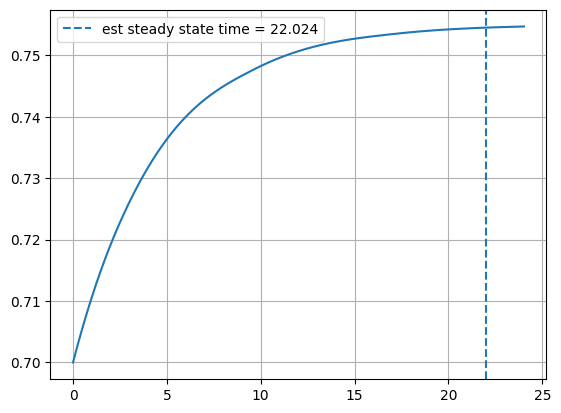

In [12]:
t_test = np.linspace(0,1, 101)
plt.plot(sol.t,sol.y.reshape(-1))
plt.axvline(est_steady_time,linestyle='--', label=f"est steady state time = {est_steady_time:.3f}")
plt.legend()
plt.grid()
sol.y.reshape(-1)[-10:]

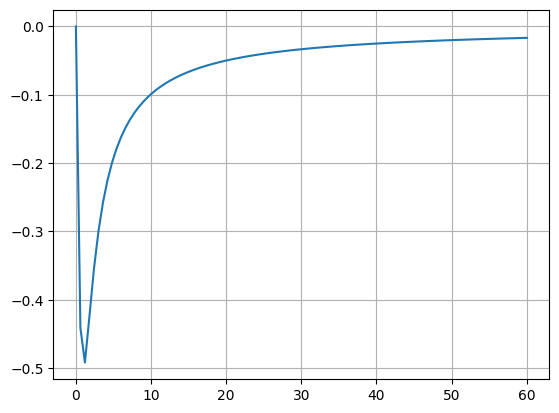

In [13]:
x_vals = np.linspace(0,60,101)
plt.plot(x_vals,f_true(x_vals))
plt.grid(True)
plt.show()

In [14]:
t_end = 22
t_span2 = [0,t_end ]
t_eval = np.linspace(0,t_end,251)
# t_eval = None
X, k, t=simulate_steady_state(k_func(t_span).astype(np.float32),x0=0.8,t_span=t_span2,t_eval=t_eval)

  0%|          | 0/251 [00:00<?, ?it/s]

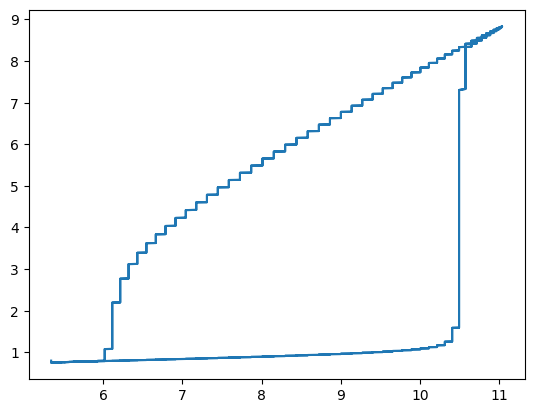

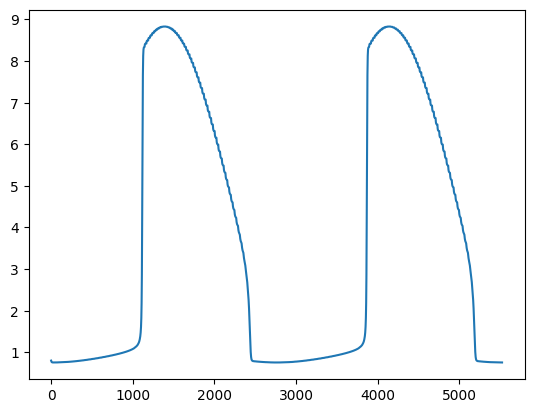

In [15]:
plt.plot(k,X[0,:])
plt.show()
plt.plot(t,X[0,:])
plt.show()

In [16]:
250*251, X.shape, k.shape

(62750, torch.Size([1, 62751]), torch.Size([62751]))

In [17]:

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X.T)
X_scaled= scaler.transform(X.T).T
X_scaled = torch.tensor(X_scaled, dtype=torch.float32, device='cpu')

In [18]:
interp_lam = interp1d(t.numpy(), k.numpy(), axis=0, kind='linear')

def control_func(t: torch.Tensor) -> torch.Tensor:
    """
    t: Tensor of shape [B] or scalar
    Returns: Tensor of shape [B, 1]
    """
    if t.dim() == 0:  # scalar time
        t_scalar = t.item()
        lam_t = torch.tensor(interp_lam(t_scalar), dtype=torch.float32)
        return lam_t.unsqueeze(0)
    else:  # batched time
        lam_t = interp_lam(t.detach().cpu().numpy())  # shape [B,]
        lam_t = torch.tensor(lam_t, dtype=torch.float32).unsqueeze(1)  # shape [B, 1]
        return lam_t.to(t.device)

In [19]:
sample_rate =100
train_idx = torch.arange(0,len(t),sample_rate)
X_train = X_scaled[:,train_idx]
t_train = t[train_idx]
k_train = k[train_idx]

In [20]:
f = Felu(1,1,4)
g = Gelu(2,1,2)

model = StabNODE(f,g).to('cpu')

In [21]:
# i=1
# model.f(X_train[:,i])

In [22]:
# t_train[i], X_train[:,i], control_func(t_train[i])

In [23]:
# X[:,:10].T.shape, control_func(t_train[:10]).shape

In [24]:
# test = torch.cat([X[:,:10].T,control_func(t_train[:10])],dim=-1)

In [25]:
# test

In [26]:
# model.g.network(test)

In [27]:
# i=1
# model(t_train[i:i+1],X_train[:,i],control_func)

In [28]:
# control_func(t[:10]).shape


In [29]:
from stabnode.utils import _load_loop_wrapper

decay_rate = 1000
dt = t[1:] - t[:-1]
dt = torch.cat((dt[0:1],dt,dt[-2:-1]))
phi_order = 5
def phi_k(i,k):
    ti = t[i]
    tk = t[k]
    return phi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

def weak_MSELoss(t,X,model,control_func, phi_order, decay_rate,show_progress=True):
    dt = t[1:] - t[:-1]
    dt = torch.cat((dt[0:1],dt,dt[-2:-1]))

    def phi_k(i,k):
        ti = t[i]
        tk = t[k]
        return phi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

    def dphi_k(i,k):
        ti=t[i]
        tk = t[k]
        return dphi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

    def integrand(i,k):
        xi = X[:,i].T
        ti = t[i]
        return dphi_k(i,k)*xi.squeeze()+phi_k(i,k)*model(ti,xi, control_func).squeeze()

    def trapezoid(k):
        indices = torch.arange(len(t))
        I = integrand(indices,k)
        trap = (dt[1:-1] / 2 ) * (I[:-1]+I[1:])
        return trap    

    K = len(t)
    weak_loss = 0.0
    loop_wrapper = _load_loop_wrapper(show_progress)
    for k in loop_wrapper(range(K)):
        weak_loss += torch.sum(trapezoid(k)**2)
    
    return weak_loss / K


In [30]:
X_scaled.shape

torch.Size([1, 62751])

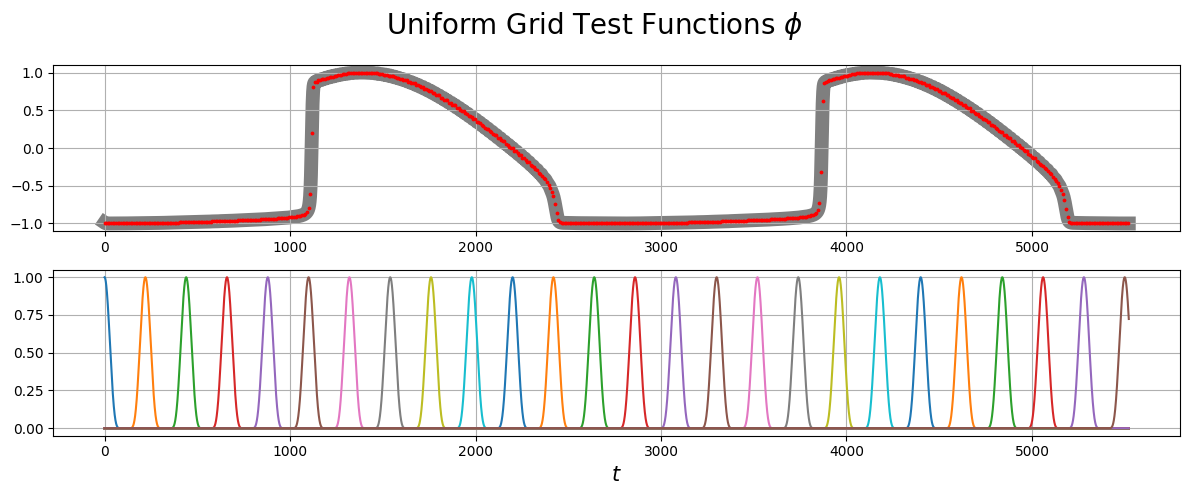

In [51]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,5))
k_vals = torch.arange(0,len(t),5000)
indices = torch.arange(len(t))

ax1.plot(t,X_scaled[0,:],c='black',alpha=0.5,lw=10,zorder=1)
ax1.scatter(t_train, X_train,zorder=2,c='red',s=3)
ax1.grid(True)
k_vals=train_idx
for k in k_vals[::25]:
    ax2.plot(t,phi_k(indices,k))

ax2.set_xlabel(r"$t$",size=15)
ax2.grid(True)
plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle(r"Uniform Grid Test Functions $\phi$", size=20)
plt.savefig("uniform_grid_phi_budworm.png")
plt.show()

In [32]:
# # test loss
# print(t_train.shape, X_train.shape)
# loss = weak_MSELoss(t_train, X_train, model, control_func, phi_order = 5, decay_rate=1000)
# loss

# format data

In [33]:
from stabnode.data import TrajectoryDataset

train_dataset = TrajectoryDataset(X_train.T, t_train, window_size=None)
len(train_dataset)

1

In [34]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

In [35]:
# for out in train_loader:
#     xi,ti,_ = out
#     loss = weak_MSELoss(ti.squeeze(),xi.squeeze().reshape(1,-1),model,control_func,phi_order=5,decay_rate=1000)
#     print(loss)

In [36]:
# xi.squeeze().reshape(1,-1)

### train model

In [37]:
import time

n_epochs = 100
lr = 1e-1
show_progress = True
phi_order = 5
decay_rate=1000
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)


loop_wrapper = _load_loop_wrapper(show_progress)
loop_wrapper2 = _load_loop_wrapper(False)

model.train()
losses = []
times = []

Xi_epoch_predictions = []
Tis_epoch = []
for epoch in loop_wrapper(range(n_epochs)):
    t1 = time.time()
    epoch_loss = 0.0
    num_batches = 0
    epoch_losses = []

    Xi_predictions = []
    Tis = []
    for Xi, Ti, _ in loop_wrapper2(train_loader):
        Xi = Xi.squeeze().reshape(1,-1) # [batch, time, dim]
        Ti = Ti.squeeze()

        if not Xi.requires_grad:
            Xi = Xi.clone().detach().requires_grad_()


        opt.zero_grad()
        loss = weak_MSELoss(
            t=Ti,
            X = Xi,
            model=model,
            control_func=control_func,
            phi_order=phi_order,
            decay_rate=decay_rate,
            show_progress=False
        )

        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1

    Xi_epoch_predictions.append(Xi_predictions)
    Tis_epoch.append(Tis)
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)

    t2 = time.time()
    times.append(t2 - t1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
losses

[20572.734375,
 10176.912109375,
 5275.19140625,
 2286.38134765625,
 950.3972778320312,
 391.642822265625,
 161.88560485839844,
 69.1072998046875,
 30.7691707611084,
 14.34660816192627,
 7.026738166809082,
 3.626739978790283,
 1.9788291454315186,
 1.143944263458252,
 0.7011436820030212,
 0.4550647735595703,
 0.311787486076355,
 0.22446849942207336,
 0.16886651515960693,
 0.13197331130504608,
 0.10654766857624054,
 0.08841369301080704,
 0.07507900148630142,
 0.06500550359487534,
 0.05721430107951164,
 0.051064521074295044,
 0.046124570071697235,
 0.04209614545106888,
 0.03876816853880882,
 0.03598770126700401,
 0.033641789108514786,
 0.03164553642272949,
 0.029933977872133255,
 0.028456643223762512,
 0.02717387117445469,
 0.026054048910737038,
 0.025071755051612854,
 0.024206362664699554,
 0.02344084531068802,
 0.022761216387152672,
 0.02215576358139515,
 0.021614694967865944,
 0.021129710599780083,
 0.02069382183253765,
 0.020300976932048798,
 0.019946034997701645,
 0.01962452009320259

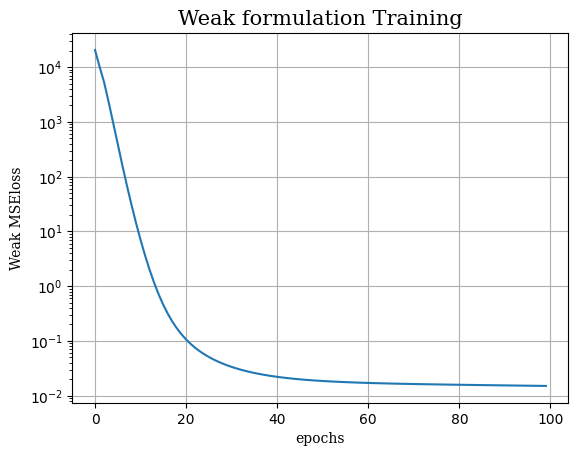

In [49]:
plt.plot(losses)
plt.xlabel("epochs", family='serif')
plt.ylabel("Weak MSEloss", family='serif')
plt.title("Weak formulation Training", family='serif', size=15)
plt.grid(True)
plt.yscale('log')
plt.savefig("weakform_budworm_loss.png")
plt.show()

## Look at learned `g` and `f`

In [40]:
def f_true(x):
    return -1*x / (1+x**2)

def g_true(x,k,r=0.56):
    return -(r/k)*x**3 + r*x**2 -(r/k)*x +r 

In [41]:
g_true_scaled_out = scaler.transform(g_true(X[:,train_idx].squeeze(),k_train).reshape(-1,1))
f_true_scaled_out = f_true(X[:,train_idx].squeeze())

In [42]:
g = model.g
f = model.f
g.eval()
f.eval()

Felu(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [43]:
X_train.shape, control_func(t_train).shape

(torch.Size([1, 628]), torch.Size([628, 1]))

In [44]:
with torch.no_grad():
    g_out = g(X_train.T, control_func(t_train))
    f_out = f(X_train.T)

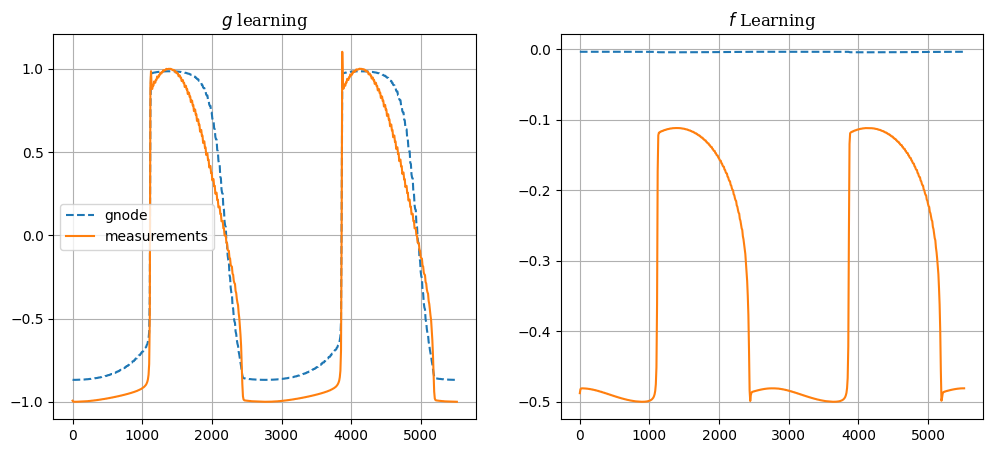

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(t_train,g_out.squeeze(),linestyle='--',label='gnode')
ax1.plot(t_train,g_true_scaled_out,label="measurements")
ax1.grid(True)
ax1.set_title(r"$g$ learning", family='serif')
ax1.legend()

ax2.plot(t_train,f_out.squeeze(),linestyle='--', label='fnode')
ax2.plot(t_train,f_true_scaled_out, label='measurements')
ax2.set_title(r"$f$ Learning", family='serif')
ax2.grid(True)
plt.savefig("weak_form_budworm_g_and_f_learning.png")
plt.show()